In [67]:
import re
import json
import random
import collections
import math
import scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
import datetime as dt

import bayesian_changepoint_detection.bayesian_changepoint_detection.offline_changepoint_detection as offcd
from sklearn.ensemble import RandomForestRegressor
import cProfile
from __future__ import division
from functools import partial

reproductie_ruw = pd.read_json("COVID-19_reproductiegetal.json")
prevalentie_ruw = pd.read_json("COVID-19_prevalentie.json")
opnames_ruw = pd.read_json("COVID-19_IC_opnames.json")
tests_ruw = pd.read_json("COVID-19_uitgevoerde_testen.json")

In [68]:
#Data functions
def latest_valid_date(x_data):
    x = x_data.columns[1]
    i = len(x_data.index)-1
    while i >= 0:
        if not(math.isnan(x_data.loc[i, x])):
            return i
        i-=1
    return(0)

def lowest_valid_date(datasets):
    laagst = 100000
    for x_data in datasets:
        datum = latest_valid_date(x_data)
        if datum < laagst:
            laagst = datum
    return laagst

def fill_front_zeroes(x_data_a, x_data_b):
    delta_time = x_data_a.loc[0, 'Date'] - x_data_b.loc[0, 'Date']
    delta_int = delta_time.days
    x = x_data_a.columns[1]
    date = x_data_a.loc[0, 'Date']
    for num in range(1, delta_int+1):
        date = date - dt.timedelta(days=1)
        row = pd.DataFrame({'Date': date, x: 0}, index=[0])
        x_data_a = pd.concat([row, x_data_a]).reset_index(drop = True)
    return x_data_a

def print_plots(datasets):
    for x_data in datasets:
        x_data.plot(x=x_data.columns[0], y=x_data.columns[1])

def print_datums(datasets):
    for x_data in datasets:
        print('First: ' +  str(x_data.loc[0, 'Date'].strftime('%d-%m-%Y')) + ' latest: ' +  str(x_data.loc[len(x_data)-1, 'Date'].strftime('%d-%m-%Y')) + ' latest valid: ' + str(x_data.loc[latest_valid_date(x_data), 'Date'].strftime('%d-%m-%Y')) + ' ' + x_data.columns[1])


In [69]:
#make a list with dates
date_list = []
for index, line in reproductie_ruw.iterrows():
    x = line["Date"]
    if x not in date_list:
        date_list.append(x)

In [70]:
#get all the data in the right shapes
reproductie_data = reproductie_ruw
reproductie_data = reproductie_data.drop(['population', 'version', 'Rt_up', 'Rt_low'], axis=1)
reproductie_data = reproductie_data.rename(columns={"Date":"Date", "Rt_avg":"Reproduction"})

prevalentie_data = prevalentie_ruw
prevalentie_data = prevalentie_data.drop(['population', 'version', 'prev_up', 'prev_low'], axis=1)
prevalentie_data = prevalentie_data.rename(columns={"Date":"Date", "prev_avg":"Prevalence"})

opnames_data = opnames_ruw
opnames_data = opnames_data.drop(['Date_of_report', 'Version', 'IC_admission_notification'], axis=1)
opnames_data = opnames_data.rename(columns={"Date_of_statistics":"Date", "IC_admission":"Intakes"})
opnames_data['Date'] = pd.to_datetime(opnames_data['Date'])

date_list_tests = []
for index, line in tests_ruw.iterrows():
    x = line["Date_of_statistics"]
    if x not in date_list_tests:
        date_list_tests.append(x)
tests_data = pd.DataFrame([], columns=['Date', 'Tests percentage'])
for date in date_list_tests:
    result_count = 0
    positive_count = 0
    count = 0
    rows = tests_ruw[tests_ruw['Date_of_statistics'] == date]
    for index, row in rows.iterrows():
        count+=1
        result_count+=row['Tested_with_result']
        positive_count+=row['Tested_positive']
    tests_data = tests_data.append({'Date': date, 'Tests percentage':100*(positive_count/result_count)}, ignore_index=True)
tests_data['Date'] = pd.to_datetime(tests_data['Date'])

print_datums([reproductie_data, prevalentie_data, opnames_data, tests_data])

First: 17-02-2020 latest: 22-07-2021 latest valid: 08-07-2021 Reproduction
First: 17-02-2020 latest: 04-07-2021 latest valid: 28-06-2021 Prevalence
First: 27-02-2020 latest: 24-07-2021 latest valid: 24-07-2021 Intakes
First: 01-06-2020 latest: 23-07-2021 latest valid: 23-07-2021 Tests percentage


In [71]:
#fill the fronts
opnames_data = fill_front_zeroes(opnames_data, prevalentie_data)
tests_data = fill_front_zeroes(tests_data, prevalentie_data)

print_datums([reproductie_data, prevalentie_data, opnames_data, tests_data])

First: 17-02-2020 latest: 22-07-2021 latest valid: 08-07-2021 Reproduction
First: 17-02-2020 latest: 04-07-2021 latest valid: 28-06-2021 Prevalence
First: 17-02-2020 latest: 24-07-2021 latest valid: 24-07-2021 Intakes
First: 17-02-2020 latest: 23-07-2021 latest valid: 23-07-2021 Tests percentage


In [72]:
#truncate the ends
data_sets = [prevalentie_data, opnames_data, reproductie_data, tests_data]

samples = lowest_valid_date(data_sets)
for i, dataset in enumerate(data_sets):
    data_sets[i] = dataset.truncate(after=samples)

print_datums(data_sets)

First: 17-02-2020 latest: 28-06-2021 latest valid: 28-06-2021 Prevalence
First: 17-02-2020 latest: 28-06-2021 latest valid: 28-06-2021 Intakes
First: 17-02-2020 latest: 28-06-2021 latest valid: 28-06-2021 Reproduction
First: 17-02-2020 latest: 28-06-2021 latest valid: 28-06-2021 Tests percentage


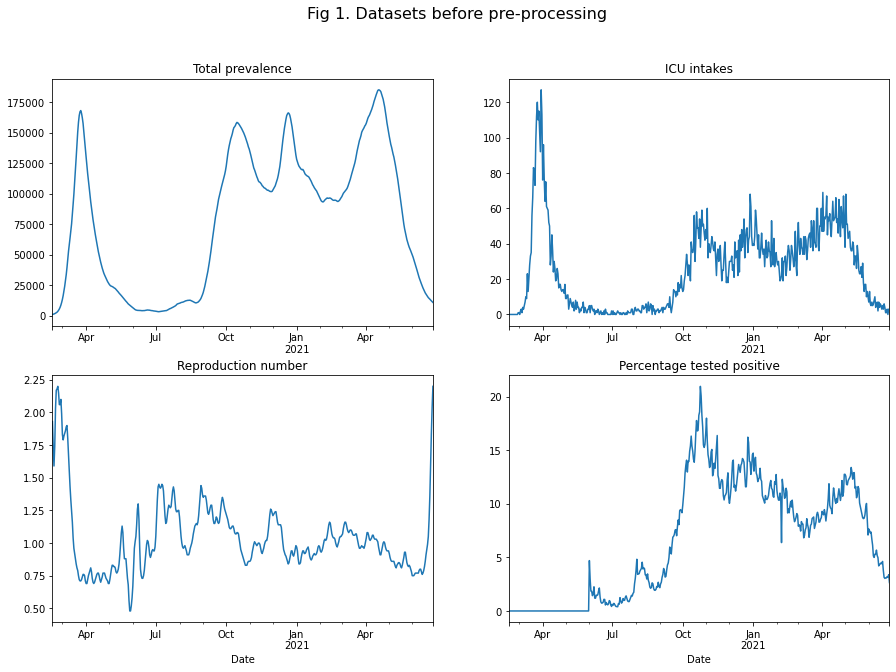

In [74]:
def print_plots_fancy(datasets):
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    datasets[0].plot(ax=axs[0, 0], x=datasets[0].columns[0], y=datasets[0].columns[1])
    datasets[1].plot(ax=axs[0, 1], x=datasets[1].columns[0], y=datasets[1].columns[1])
    datasets[2].plot(ax=axs[1, 0], x=datasets[2].columns[0], y=datasets[2].columns[1])
    datasets[3].plot(ax=axs[1, 1], x=datasets[3].columns[0], y=datasets[3].columns[1])
    axs[0,0].set_title('Total prevalence')
    axs[0,1].set_title('ICU intakes')
    axs[1,0].set_title('Reproduction number')
    axs[1,1].set_title('Percentage tested positive')
    axs[0,0].get_legend().remove()
    axs[0,1].get_legend().remove()
    axs[1,0].get_legend().remove()
    axs[1,1].get_legend().remove()
    axs[0,0].set(xlabel='')
    axs[0,1].set(xlabel='')
    fig.suptitle('Fig 1. Datasets before pre-processing', fontsize=16)
    
print_plots_fancy(data_sets)

In [75]:
#data processing functions
#deltas
def maak_deltas(datasets):
    deltas_set = []
    for x_data in datasets:
        time = x_data.columns[0]
        x = x_data.columns[1]
        x_deltas = pd.DataFrame([], columns=[time, x])
        i = 0
        for index, row in x_data.iterrows():
            if index!=0:
                delta = x_data.loc[index, x] - x_data.loc[index-1 , x]
                x_deltas = x_deltas.append({time: row[time], x: delta}, ignore_index=True)
        deltas_set.append(x_deltas)
    return deltas_set

#weken
def maak_weken(datasets):
    weken_set = []
    for x_data in datasets:
        x = x_data.columns[1]
        x_weken = pd.DataFrame([], columns=['weeknr', x])
        i = 0
        limit = math.floor((samples+1)/7)
        while i < limit:
            avg = 0
            for num in range(7):
                avg += x_data.loc[(i*7)+num, x]
            x_weken = x_weken.append({'weeknr': int(i), x: avg/7}, ignore_index=True)
            i+=1
        weken_set.append(x_weken)
    return weken_set

#functies voor normaliseren
def calc_deviation(x_data):
    x = x_data.columns[1]
    mean = x_data[x].sum() / len(x_data.index)
    i = 0
    for index, row in x_data.iterrows():
        i += (row[x] - mean) ** 2
    variation = i / (len(x_data.index)-1)
    return(math.sqrt(variation))

def make_regression(x_data):
    rf = RandomForestRegressor(n_estimators = 20, random_state = 0, max_depth=5)
    x = x_data.index.tolist()
    x = np.array(x)
    x = x.reshape(-1, 1)
    y = x_data[x_data.columns[1]]
    rf.fit(x,y)
    regression = rf.predict(x)
    return(regression)

def calc_diffs(x_data, regression):
    x = x_data.columns[1]
    time = x_data.columns[0]
    x_verschillen = pd.DataFrame([], columns=[time, x])
    for index, row in x_data.iterrows():
        dif = row[x] - regression[index]
        x_verschillen = x_verschillen.append({time:row[time], x:dif}, ignore_index=True)
    return(x_verschillen)
    
def normaliseer(datasets):
    normalised_set = []
    for x_data in datasets:
        time = x_data.columns[0]
        x = x_data.columns[1]
        regression = make_regression(x_data)
        verschil = calc_diffs(x_data, regression)
        deviation = calc_deviation(verschil)
        x_normal = pd.DataFrame([], columns=[time, x])
        for index, row in x_data.iterrows():
            x_normal = x_normal.append({time:row[time], x:row[x]/deviation}, ignore_index=True)
        normalised_set.append(x_normal)
    return normalised_set

#for bayesian
def make_np_array(data_merged):
    result_list = []
    for i in range(len(data_merged)):
        result_list.append([data_merged.loc[i,data_merged.columns[1]], 
                          data_merged.loc[i,data_merged.columns[2]],
                          data_merged.loc[i,data_merged.columns[3]],
                          data_merged.loc[i,data_merged.columns[4]]])
    return np.array(result_list)

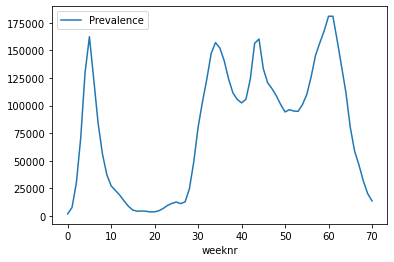

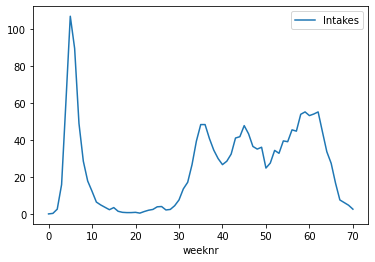

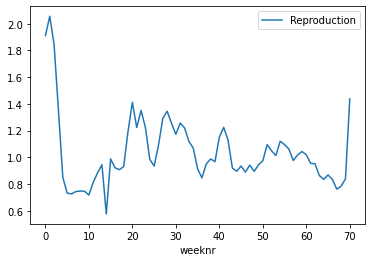

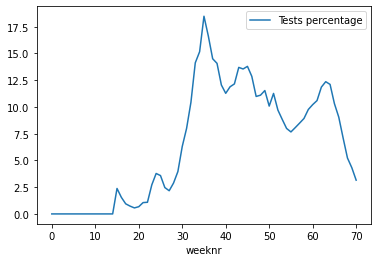

In [76]:
#weken
data_weken = maak_weken(data_sets)

print_plots(data_weken)

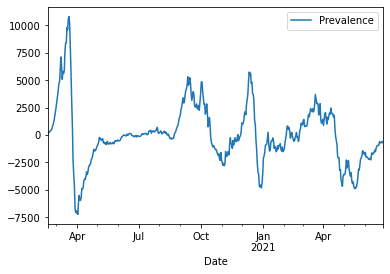

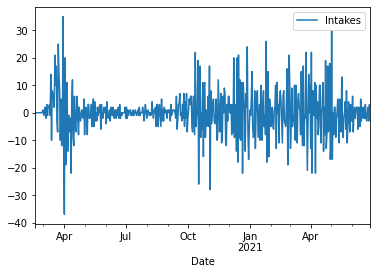

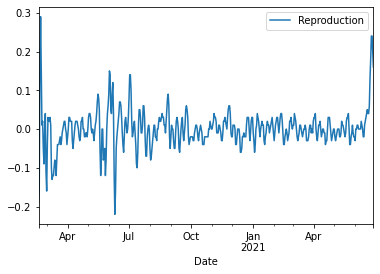

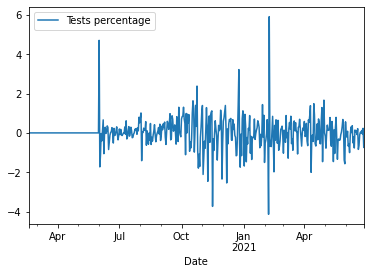

In [77]:
#deltas
data_deltas = maak_deltas(data_sets)
print_plots(data_deltas)

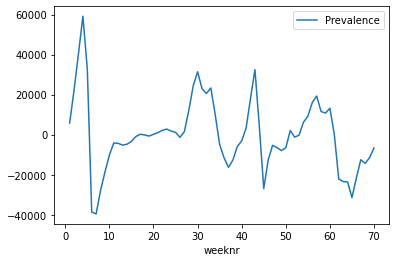

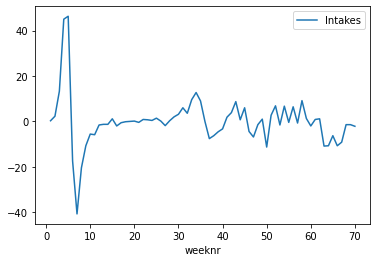

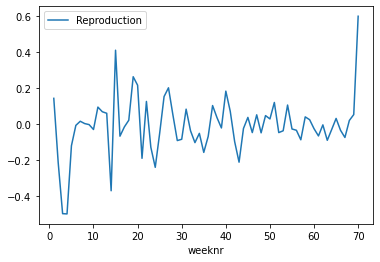

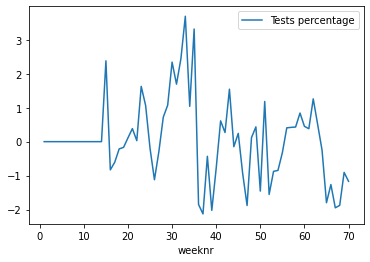

In [78]:
#deltas van weken
data_dw = maak_deltas(maak_weken(data_sets))

print_plots(data_dw)

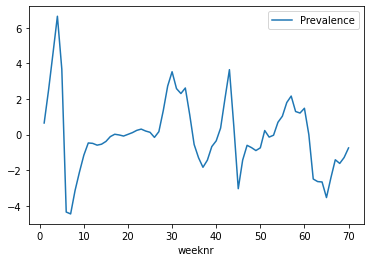

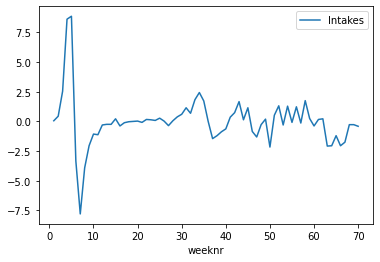

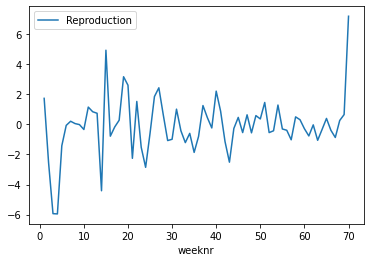

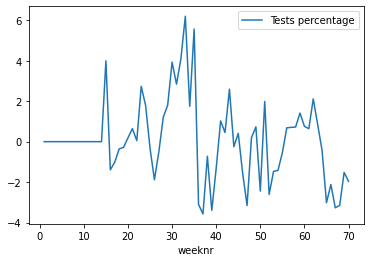

In [79]:
#normalised
data_normal = normaliseer(data_dw)

print_plots(data_normal)

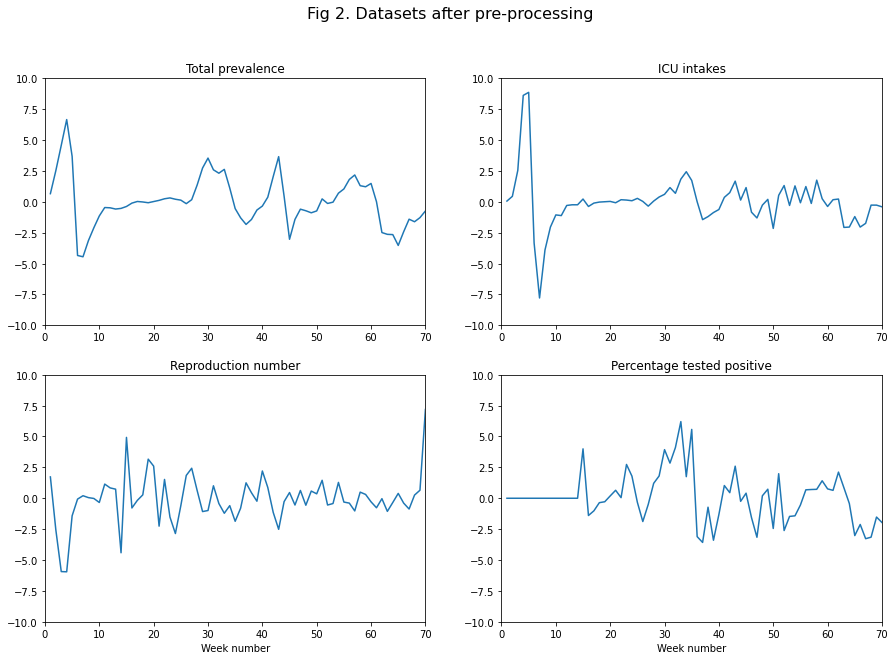

In [80]:
def print_plots_fancy2(datasets):
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    datasets[0].plot(ax=axs[0, 0], x=datasets[0].columns[0], y=datasets[0].columns[1])
    datasets[1].plot(ax=axs[0, 1], x=datasets[1].columns[0], y=datasets[1].columns[1])
    datasets[2].plot(ax=axs[1, 0], x=datasets[2].columns[0], y=datasets[2].columns[1])
    datasets[3].plot(ax=axs[1, 1], x=datasets[3].columns[0], y=datasets[3].columns[1])
    axs[0,0].set_title('Total prevalence')
    axs[0,1].set_title('ICU intakes')
    axs[1,0].set_title('Reproduction number')
    axs[1,1].set_title('Percentage tested positive')
    axs[0,0].get_legend().remove()
    axs[0,1].get_legend().remove()
    axs[1,0].get_legend().remove()
    axs[1,1].get_legend().remove()
    axs[0,0].set(xlabel='')
    axs[0,1].set(xlabel='')
    axs[1,0].set(xlabel='Week number')
    axs[1,1].set(xlabel='Week number')
    axs[0,0].axis([0,70,-10,10])
    axs[0,1].axis([0,70,-10,10])
    axs[1,0].axis([0,70,-10,10])
    axs[1,1].axis([0,70,-10,10])
    fig.suptitle('Fig 2. Datasets after pre-processing', fontsize=16)
    
print_plots_fancy2(data_normal)

In [81]:
#changepoint functies
def drop_dates(x_data):
    return(x_data.drop([x_data.columns[0]], axis=1))

def merge_sets(datasets):
    total_set = datasets[0].merge(datasets[1]).merge(datasets[2]).merge(datasets[3])
    return(total_set)
    
def print_bkps(bkps):
    for bkp in bkps:
        print(str(bkp) + ' date: ' + str(date_list[(bkp+1)*7].strftime('%d-%m-%Y')))
        
def print_bkps_nrs(bkps):
    bkp_nrs = []
    for bkp in bkps:
        bkp_nrs.append(bkp)
    bkp_nrs.pop()
    print(bkp_nrs)

def print_bkps_dates(bkps):
    bkp_weeks = []
    for bkp in bkps:
        bkp_weeks.append(date_list[(bkp+1)*7].strftime('%d-%m-%Y'))
    bkp_weeks.pop()
    print(bkp_weeks)

In [82]:
#merge datasets
final_sets = merge_sets(data_normal)
#set penalty value for the ruptures algorithms
penalty = 10

In [83]:
def print_plots_results(datasets, bkps, title='', nr=0):
    fig, axs = plt.subplots(4, figsize=(10,10))
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(hspace=0.3)
    datasets[0].plot(ax=axs[0], x=datasets[0].columns[0], y=datasets[0].columns[1], color='green')
    datasets[1].plot(ax=axs[1], x=datasets[1].columns[0], y=datasets[1].columns[1], color='green')
    datasets[2].plot(ax=axs[2], x=datasets[2].columns[0], y=datasets[2].columns[1], color='green')
    datasets[3].plot(ax=axs[3], x=datasets[3].columns[0], y=datasets[3].columns[1], color='green')
    axs[0].set_title('Fig ' + str(nr) + '.' + str(1) + '.' + ' Total prevalence')
    axs[1].set_title('Fig ' + str(nr) + '.' + str(2) + '.' + ' ICU intakes')
    axs[2].set_title('Fig ' + str(nr) + '.' + str(3) + '.' + ' Reproduction number')
    axs[3].set_title('Fig ' + str(nr) + '.' + str(4) + '.' + ' Percentage tested positive')
    axs[0].get_legend().remove()
    axs[1].get_legend().remove()
    axs[2].get_legend().remove()
    axs[3].get_legend().remove()
    axs[0].set(xlabel='')
    axs[1].set(xlabel='')
    axs[2].set(xlabel='')
    axs[3].set(xlabel='Week number')
    axs[0].axis([0,70,-10,10])
    axs[1].axis([0,70,-10,10])
    axs[2].axis([0,70,-10,10])
    axs[3].axis([0,70,-10,10])
    for ax in axs:
        redYN = False
        last_bkp = 0
        for bkp in bkps:
            if redYN:
                ax.axvspan(last_bkp, bkp, facecolor='#FFBFBF')
                last_bkp = bkp
                redYN = False
            else:
                ax.axvspan(last_bkp, bkp, facecolor='#BFFCFF')
                last_bkp = bkp
                redYN = True
    plt.show()

In [103]:
#bayesian mutli
relevante_data = final_sets
relevante_np = make_np_array(relevante_data)

Q, P, Pcp = offcd.offline_changepoint_detection(relevante_np, partial(offcd.const_prior, l=(len(relevante_np)+1)), offcd.gaussian_obs_log_likelihood, truncate=-20)
results = np.exp(Pcp).sum(0)

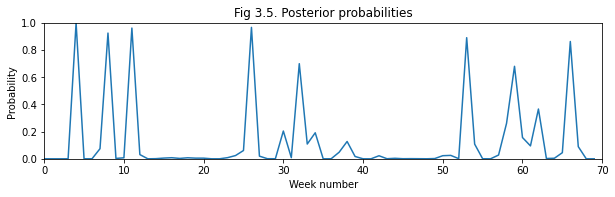

In [104]:
#bayes posteriors
fig, axs = plt.subplots(1, figsize=(10,2.5))
yvals = list(range(70))
posteriors=np.append(results,[0])
axs.plot(yvals, posteriors)
axs.set_xlabel('Week number')
axs.set_ylabel('Probability')
axs.axis([0,70,0,1])
axs.set_title('Fig 3.5. Posterior probabilities')
plt.show()

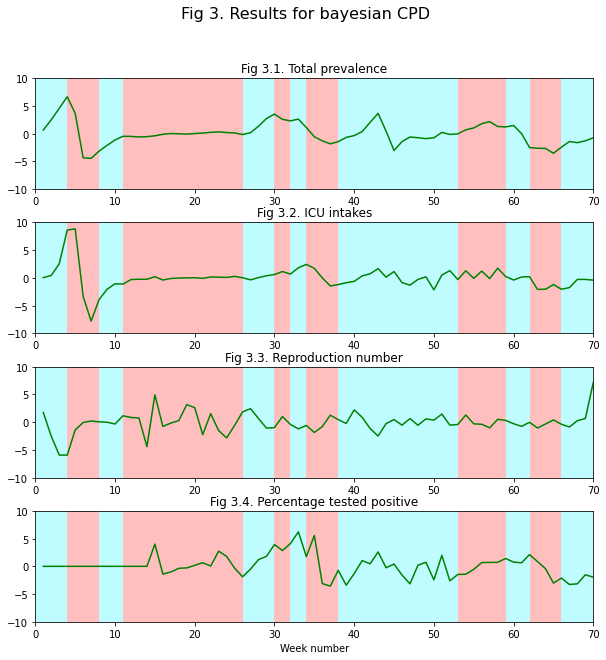

In [105]:
results[results < 0.1] = 0 
bkps_array = scipy.signal.find_peaks(results)[0]
bayes_bkps = bkps_array.tolist()
bayes_bkps.append(len(relevante_data.index))

print_plots_results(data_normal, bayes_bkps, 'Fig 3. Results for bayesian CPD', 3)

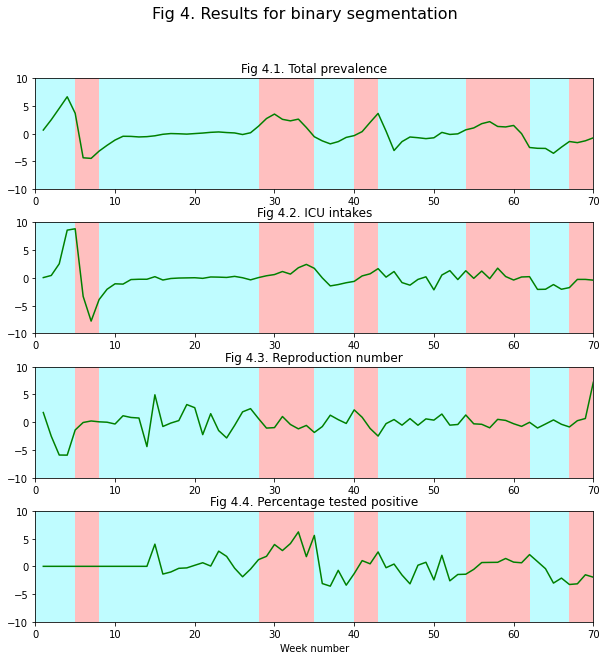

In [86]:
#binary segmentation
relevante_data = final_sets
relevante_data = drop_dates(relevante_data)

algo = rpt.Binseg(model="l2", jump=1).fit(relevante_data)
binseg_bkps = algo.predict(pen=penalty)

print_plots_results(data_normal, binseg_bkps, 'Fig 4. Results for binary segmentation', 4)

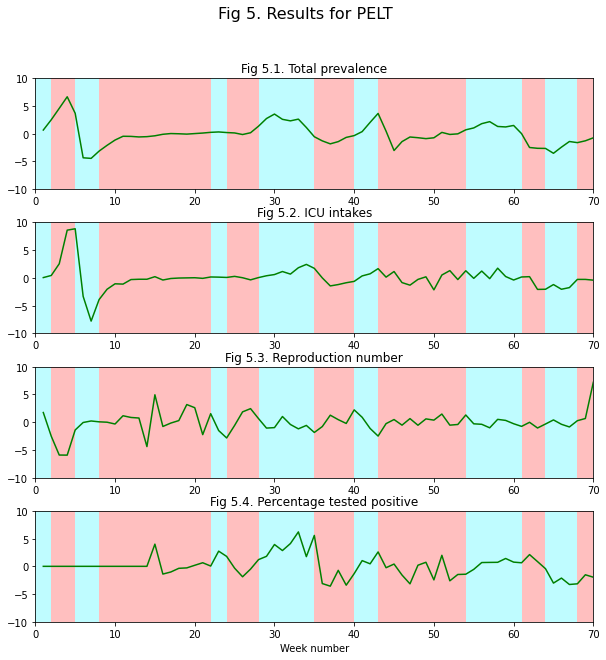

In [87]:
#kernel based, aka PELT v2
relevante_data = final_sets
relevante_data = drop_dates(relevante_data)

algo = rpt.Pelt(model="l2", jump=1).fit(relevante_data)
PELT_bkps = algo.predict(pen=penalty)

print_plots_results(data_normal, PELT_bkps, 'Fig 5. Results for PELT', 5)

In [107]:
print('bayes')
print_bkps_nrs(bayes_bkps)
print_bkps_dates(bayes_bkps)
print('binseg')
print_bkps_nrs(binseg_bkps)
print_bkps_dates(binseg_bkps)
print('pelt')
print_bkps_nrs(PELT_bkps)
print_bkps_dates(PELT_bkps)

bayes
[4, 8, 11, 26, 30, 32, 34, 38, 53, 59, 62, 66]
['23-03-2020', '20-04-2020', '11-05-2020', '24-08-2020', '21-09-2020', '05-10-2020', '19-10-2020', '16-11-2020', '01-03-2021', '12-04-2021', '03-05-2021', '31-05-2021']
binseg
[5, 8, 28, 35, 40, 43, 54, 62, 67]
['30-03-2020', '20-04-2020', '07-09-2020', '26-10-2020', '30-11-2020', '21-12-2020', '08-03-2021', '03-05-2021', '07-06-2021']
pelt
[2, 5, 8, 22, 24, 28, 35, 40, 43, 54, 61, 64, 68]
['09-03-2020', '30-03-2020', '20-04-2020', '27-07-2020', '10-08-2020', '07-09-2020', '26-10-2020', '30-11-2020', '21-12-2020', '08-03-2021', '26-04-2021', '17-05-2021', '14-06-2021']


In [89]:
#the combined results list
print_bkps([4,5,8,26,28,34,35,38,40,43,53,54,61,62,66,68])

4 date: 23-03-2020
5 date: 30-03-2020
8 date: 20-04-2020
26 date: 24-08-2020
28 date: 07-09-2020
34 date: 19-10-2020
35 date: 26-10-2020
38 date: 16-11-2020
40 date: 30-11-2020
43 date: 21-12-2020
53 date: 01-03-2021
54 date: 08-03-2021
61 date: 26-04-2021
62 date: 03-05-2021
66 date: 31-05-2021
68 date: 14-06-2021


In [90]:
#bayesian time
relevante_data = final_sets
relevante_np = make_np_array(relevante_data)
%timeit Q, P, Pcp = offcd.offline_changepoint_detection(relevante_np, partial(offcd.const_prior, l=(len(relevante_np)+1)), offcd.gaussian_obs_log_likelihood, truncate=-20)

89.3 ms ± 728 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
#binseg time
relevante_data = final_sets
relevante_data = drop_dates(relevante_data)

algo = rpt.Binseg(model="l2", jump=1).fit(relevante_data)
%timeit binseg_bkps = algo.predict(pen=penalty)

3.11 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
#PELT time
relevante_data = final_sets
relevante_data = drop_dates(relevante_data)

algo = rpt.Pelt(model="l2", jump=1).fit(relevante_data)
%timeit PELT_bkps = algo.predict(pen=penalty)

85.7 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


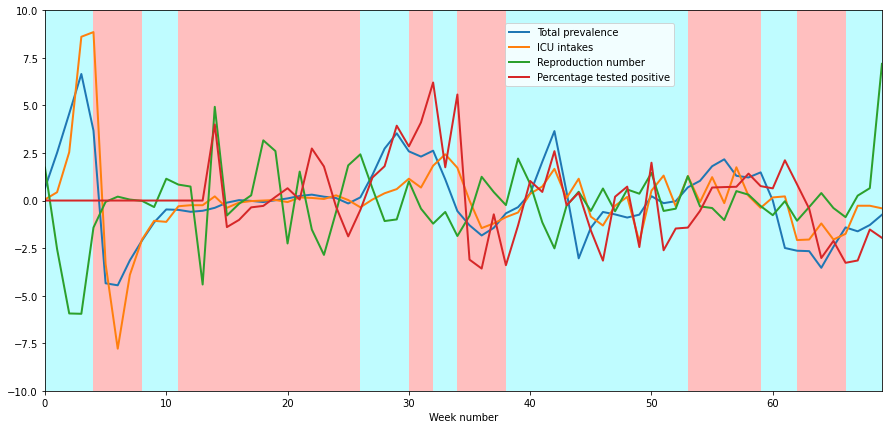

In [93]:
#alternative plot function
def make_plot(my_bkps, data):
    fig, ax = plt.subplots(figsize=[15,7])
    plt.axis([0,69,-10,10])
    ax.plot(data[data.columns[0]], label='Total prevalence', linewidth=2)
    ax.plot(data[data.columns[1]], label='ICU intakes', linewidth=2)
    ax.plot(data[data.columns[2]], label='Reproduction number', linewidth=2)
    ax.plot(data[data.columns[3]], label='Percentage tested positive', linewidth=2)
    redYN = False 
    last_bkp = 0
    for bkp in my_bkps:
        if redYN:
            ax.axvspan(last_bkp, bkp, facecolor='#FFBFBF')
            last_bkp = bkp
            redYN = False
        else:
            ax.axvspan(last_bkp, bkp, facecolor='#BFFCFF')
            last_bkp = bkp
            redYN = True
    plt.legend(loc=[0.55,0.8])
    ax.set(xlabel='Week number')
    plt.show()
make_plot(bayes_bkps, drop_dates(final_sets))


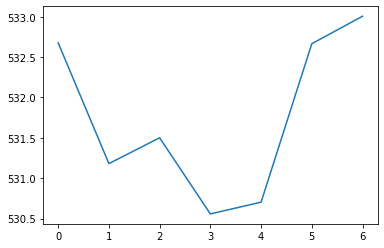

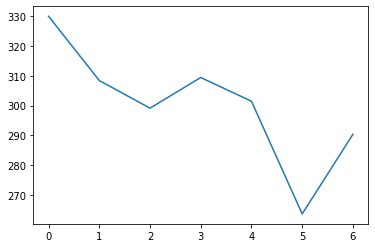

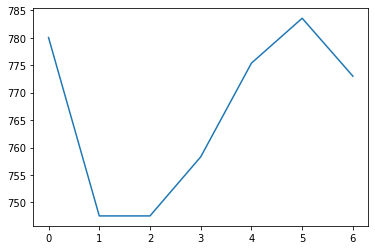

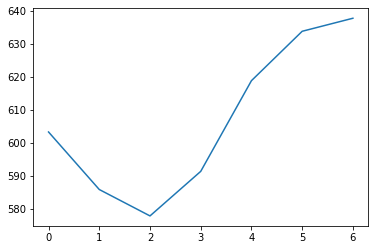

In [95]:
#some inspections of the data
#plots the deviations throughout a week
def week_overzicht(datasets):
    for x_data in datasets:
        x = x_data.columns[1]
        weekdag = 0
        waardes = [0] * 7
        for index, row in x_data.iterrows():
            waardes[weekdag] += row[x]
            if weekdag == 6:
                weekdag = 0
            else:
                weekdag+=1
        plt.plot(waardes)
        
        plt.show()
    
week_overzicht(normaliseer(data_sets))

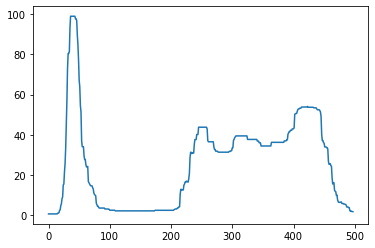

In [96]:
#a generated regression
x_data = data_sets[1]
rf = RandomForestRegressor(n_estimators = 20, random_state = 0, max_depth=5)
x = x_data.index.tolist()
x = np.array(x)
x = x.reshape(-1, 1)
y = x_data[x_data.columns[1]]
rf.fit(x,y)
regression = rf.predict(x)
plt.plot(regression)

Intakes


<AxesSubplot:>

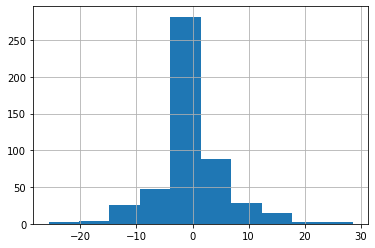

In [97]:
#histogram of difference between regression and actual values
x_data = data_sets[1]
time = x_data.columns[0]
x = x_data.columns[1]
print(x)
regression = make_regression(x_data)
verschil = calc_diffs(x_data, regression)
verschil[x].hist()